In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))
conv_base.summary() 
# base_dir = 'C:/Users/xiaoc/Downloads/dogs-vs-cats/neww'
# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')
# this method 1:  fast feature extraction without data augmentation 
train_dir = 'C:/Users/xiaoc/Downloads/dogs-vs-cats/new/train' 
validation_dir = 'C:/Users/xiaoc/Downloads/dogs-vs-cats/new/validation'
test_dir = 'C:/Users/xiaoc/Downloads/dogs-vs-cats/new/test'







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
____

In [4]:

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [5]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
train_features.shape
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [9]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(train_features, train_labels,
epochs=30,
batch_size=20,
validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5918 - acc: 0.6855 - val_loss: 0.4304 - val_acc: 0.8410
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4182 - acc: 0.8125 - val_loss: 0.3547 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3572 - acc: 0.8465 - val_loss: 0.3245 - val_acc: 0.8650
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3042 - acc: 0.8790 - val_loss: 0.3004 - val_acc: 0.8770
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2781 - acc: 0.8880 - val_loss: 0.2843 - val_acc: 0.8840
Epoch 6/30
2000/2000 [==============================] - 2s 939us/step - 

<IPython.core.display.Javascript object>


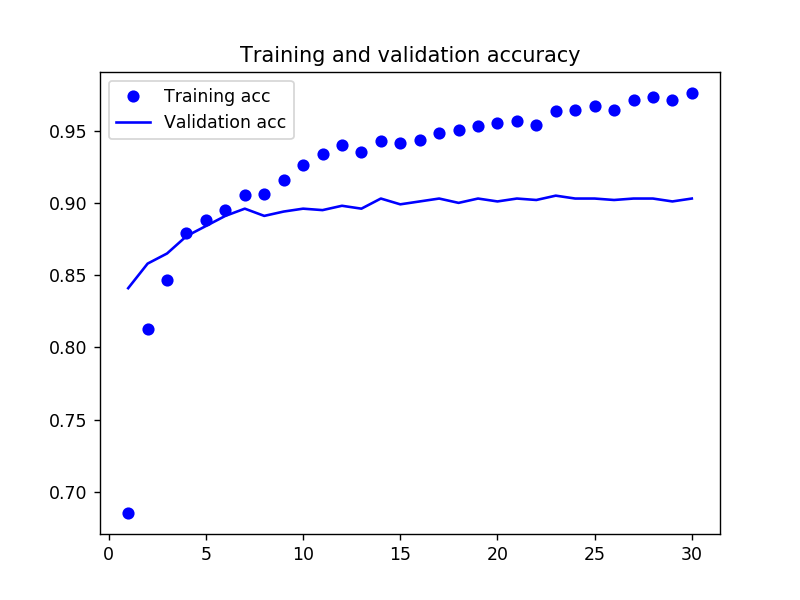

<IPython.core.display.Javascript object>


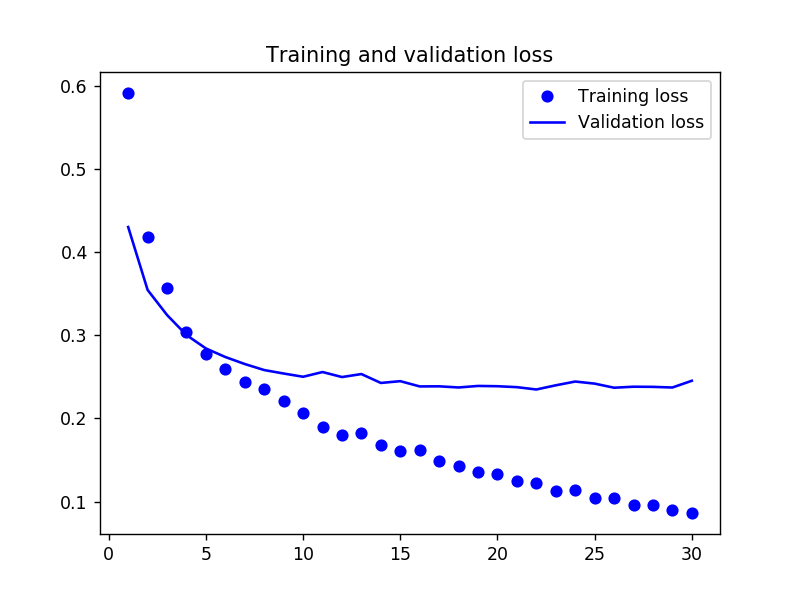

In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
# this is method 2 : extending the conv_base model and running it end to end on the inputs. with data augmentation

from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [14]:
conv_base.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [16]:
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=2e-5),
metrics=['acc'])
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 51s 507ms/step - loss: 0.6102 - acc: 0.6810 - val_loss: 0.4588 - val_acc: 0.8150
Epoch 2/30
100/100 [==============================] - 50s 496ms/step - loss: 0.4845 - acc: 0.7840 - val_loss: 0.3800 - val_acc: 0.8480
Epoch 3/30
100/100 [==============================] - 50s 496ms/step - loss: 0.4321 - acc: 0.8135 - val_loss: 0.3300 - val_acc: 0.8680
Epoch 4/30
100/100 [==============================] - 50s 497ms/step - loss: 0.4076 - acc: 0.8145 - val_loss: 0.3065 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 50s 497ms/step - loss: 0.3835 - acc: 0.8340 - val_loss: 0.2906 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 50s 499ms/step - loss: 0.3576 - acc: 0.8510 - val_loss: 0.2817 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 50s 497ms/step - loss: 0.3644 - acc: 0.8290 - val_lo

<IPython.core.display.Javascript object>


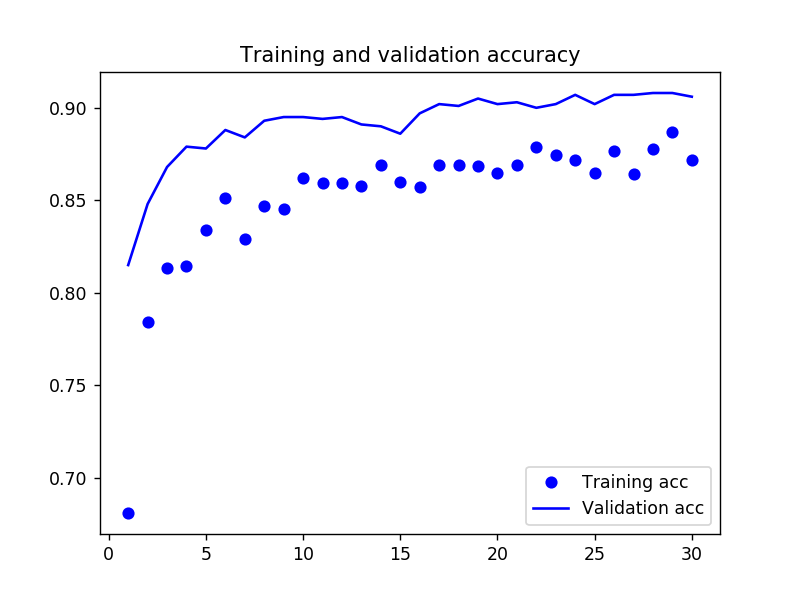

<IPython.core.display.Javascript object>


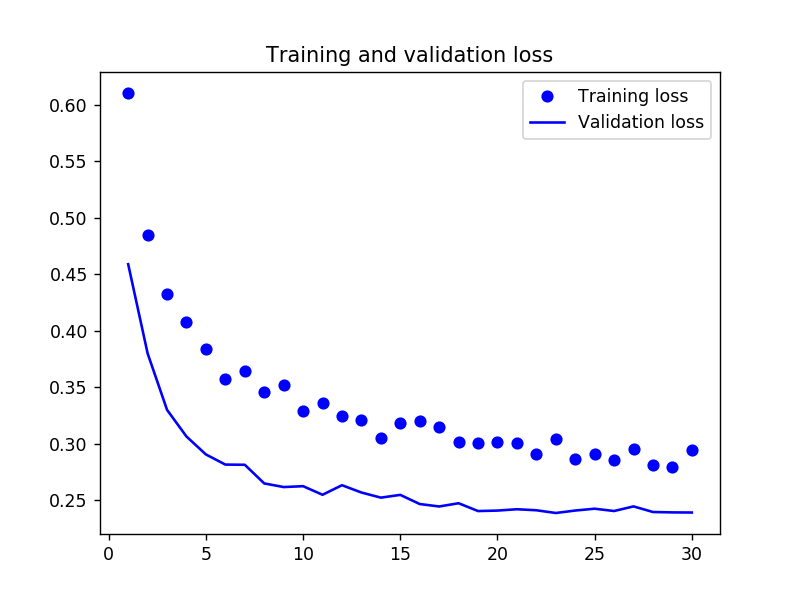

In [17]:
import matplotlib.pyplot as plt
%matplotlib notebook
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()